In [2]:

import os
import sys
import argparse
import math
import numpy as np
import timeit
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv
from src.general.utils import cc_path

sys.path.append(gv.PROJECT_PATH)


sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

# def load_data(data_path, max_length, vocab_size, batch_size=64):
#     X_trn, Y_trn, X_tst, Y_tst, vocabulary, vocabulary_inv = data_helpers.load_data(data_path, max_length=max_length,
#                                                                                     vocab_size=vocab_size)
#     Y_trn = Y_trn[0:].toarray()
#     Y_trn = np.insert(Y_trn, 101, 0, axis=1)
#     Y_trn = np.insert(Y_trn, 102, 0, axis=1)
#     Y_tst = Y_tst[0:].toarray()
#
#     train_data = data_utils.TensorDataset(torch.from_numpy(X_trn).type(torch.LongTensor),
#                                           torch.from_numpy(Y_trn).type(torch.LongTensor))
#     test_data = data_utils.TensorDataset(torch.from_numpy(X_tst).type(torch.LongTensor),
#                                          torch.from_numpy(Y_tst).type(torch.LongTensor))
#     train_loader = data_utils.DataLoader(train_data, batch_size, drop_last=False, shuffle=True)
#     test_loader = data_utils.DataLoader(test_data, batch_size, drop_last=False)
#     return train_loader, test_loader, vocabulary, X_tst, Y_tst, X_trn, Y_trn

def precision_k(pred, label, k=[1, 3, 5]):
    batch_size = pred.shape[0]

    precision = []
    for _k in k:
        p = 0
        for i in range(batch_size):
            p += label[i, pred[i, :_k]].mean()
        precision.append(p * 100 / batch_size)

    return precision


def ndcg_k(pred, label, k=[1, 3, 5]):
    batch_size = pred.shape[0]

    ndcg = []
    for _k in k:
        score = 0
        rank = np.log2(np.arange(2, 2 + _k))
        for i in range(batch_size):
            l = label[i, pred[i, :_k]]
            n = l.sum()
            if (n == 0):
                continue

            dcg = (l / rank).sum()
            label_count = label[i].sum()
            norm = 1 / np.log2(np.arange(2, 2 + np.min((_k, label_count))))
            norm = norm.sum()
            score += dcg / norm

        ndcg.append(score * 100 / batch_size)

    return ndcg


# input data_path
# data_path = '/data/rcv1_raw_text.p'
sequence_length = 500
batch_size = 64

def load_glove_embeddings(path, embedding_dim):
    """Loading the glove embeddings"""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        embeddings = np.zeros((len(lines)+1, embedding_dim))
        word_idx_dict = {}
        for index, line in tqdm(enumerate(lines), desc='vocab building: '):
            values = line.split()
            word = values[0]
            word_idx_dict[word] = index + 1
            if index:
                vector = np.array(values[1:], dtype='float32')
                if vector.shape[-1] != embedding_dim:
                    raise Exception('Dimension not matching.')
                embeddings[index] = vector

    return torch.from_numpy(embeddings).float(), word_idx_dict




# load glove
pretrain = 'glove'
embedding_dim = 256
# input word2vec file path
file_path = cc_path(f'data/processed/canary/word_embeddings_{pretrain}_2023-04-11.csv')
embedding_weights, word_idx_dict = load_glove_embeddings(file_path, embedding_dim)


vocab building: : 456009it [01:04, 7053.74it/s]


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [4]:
print('-' * 50)
print('Loading data...');
start_time = timeit.default_timer()
# load all the data
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'author_network': cc_path('data/processed/canary/author_network.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()

processed_df['pui'] = processed_df['pui'].astype(str)


label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]
label_columns.loc[:, label_columns.columns.difference(['pui'])] = label_columns.loc[
                                                                  :, label_columns.columns.difference(['pui'])].astype(str)

with open(cc_path(f'data/train_indices.txt')) as f:
    train_puis = f.read().splitlines()
with open(cc_path(f'data/val_indices.txt')) as f:
    val_puis = f.read().splitlines()
with open(cc_path(f'data/test_indices.txt')) as f:
    test_puis = f.read().splitlines()
        
processed_df['str_keywords'] = processed_df['keywords'].str.replace('[', ' ').str.replace(']', ' ').str.replace(', ', ' ').str.replace("'", '')
processed_df['embedding_text'] = processed_df['title'] + processed_df['str_keywords'] + processed_df['abstract']


--------------------------------------------------
Loading data...


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [5]:
train_set = processed_df[processed_df.pui.isin(train_puis)]
val_set = processed_df[processed_df.pui.isin(val_puis)]
test_set = processed_df[processed_df.pui.isin(test_puis)]

In [6]:
train_labels = label_columns.loc[processed_df.pui.isin(train_puis), label_columns.columns.difference(['pui'])].to_numpy(dtype=np.int8)
val_labels = label_columns.loc[processed_df.pui.isin(val_puis), label_columns.columns.difference(['pui'])].to_numpy(dtype=np.int8)
test_labels = label_columns.loc[processed_df.pui.isin(test_puis), label_columns.columns.difference(['pui'])].to_numpy(dtype=np.int8)


In [7]:
train_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [8]:
# processed_df['embedding_text'] = processed_df['embedding_text'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])
train_set['abstract'] = train_set['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])
val_set['abstract'] = val_set['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])
test_set['abstract'] = test_set['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])

/tmp/ipykernel_1015/504266889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['abstract'] = train_set['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])
/tmp/ipykernel_1015/504266889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['abstract'] = val_set['abstract'].apply(lambda x: [int(word_idx_dict[word]) for word in x.split(' ')])
/tmp/ipykernel_1015/504266889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

<Axes: >

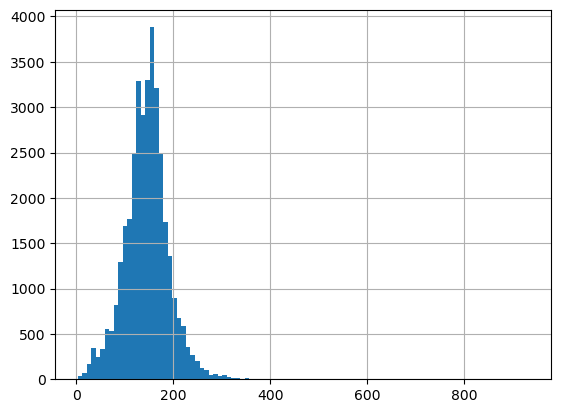

In [15]:
train_set['abstract'].apply(len).hist(bins=100)

In [9]:
set_width = 200
train_set['abstract'] = train_set['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])
val_set['abstract'] = val_set['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])
test_set['abstract'] = test_set['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])


/tmp/ipykernel_1015/3275558676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['abstract'] = train_set['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])
/tmp/ipykernel_1015/3275558676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['abstract'] = val_set['abstract'].apply(lambda x: x + [0] * (set_width - len(x)) if len(x) <= set_width else x[:set_width])
/tmp/ipykernel_1015/3275558676.py:4: SettingWithCopyWarning: 
A value is tryin

In [43]:
batch_size=64
train_data = data_utils.TensorDataset(torch.from_numpy(np.array(train_set['abstract'].to_list(), dtype=int)).type(torch.LongTensor).to(device),
                                      torch.from_numpy(train_labels).type(torch.LongTensor).to(device))
val_data = data_utils.TensorDataset(torch.from_numpy(np.array(val_set['abstract'].to_list(), dtype=int)).type(torch.LongTensor).to(device),
                                     torch.from_numpy(val_labels).type(torch.LongTensor).to(device))
test_data = data_utils.TensorDataset(torch.from_numpy(np.array(test_set['abstract'].to_list(), dtype=int)).type(torch.LongTensor).to(device),
                                     torch.from_numpy(test_labels).type(torch.LongTensor).to(device))
train_loader = data_utils.DataLoader(train_data, batch_size, drop_last=False, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size, drop_last=False)
test_loader = data_utils.DataLoader(test_data, batch_size, drop_last=False)


# train_loader, test_loader, vocabulary, X_tst, Y_tst, X_trn, Y_trn = load_data(data_path, sequence_length, vocab_size,
#                                                                               batch_size)
print('Process time %.3f (secs)\n' % (timeit.default_timer() - start_time))




vocab_size = embedding_weights.size(0)

# create Network structure

Process time 6181.528 (secs)



In [1]:

class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path=None):
        if path is None:
            raise ValueError('Please specify the saving road!!!')
        torch.save(self.state_dict(), path)
        return path


# In[9]:


def get_embedding_layer(embedding_weights):
    word_embeddings = nn.Embedding(num_embeddings=embedding_weights.size(0), embedding_dim=embedding_weights.size(1))
    word_embeddings.weight.data.copy_(embedding_weights)
    word_embeddings.weight.requires_grad = False  # not train
    return word_embeddings


class Hybrid_XML(BasicModule):
    def __init__(self, num_labels=3714, vocab_size=30001, embedding_size=300, embedding_weights=None,
                 max_seq=300, hidden_size=256, d_a=256, label_emb=None):
        super(Hybrid_XML, self).__init__()
        self.embedding_size = embedding_size
        self.num_labels = num_labels
        self.max_seq = max_seq
        self.hidden_size = hidden_size

        if embedding_weights is None:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        else:
            self.word_embeddings = get_embedding_layer(embedding_weights)

        self.lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1,
                            batch_first=True, bidirectional=True)

        # interaction-attention layer
        self.key_layer = torch.nn.Linear(2 * self.hidden_size, self.hidden_size)
        self.query_layer = torch.nn.Linear(self.hidden_size, self.hidden_size)

        # self-attn layer
        self.linear_first = torch.nn.Linear(2 * self.hidden_size, d_a)
        self.linear_second = torch.nn.Linear(d_a, self.num_labels)

        # weight adaptive layer
        self.linear_weight1 = torch.nn.Linear(2 * self.hidden_size, 1)
        self.linear_weight2 = torch.nn.Linear(2 * self.hidden_size, 1)

        # shared for all attention component
        self.linear_final = torch.nn.Linear(2 * self.hidden_size, self.hidden_size)
        self.output_layer = torch.nn.Linear(self.hidden_size, 1)

        label_embedding = torch.FloatTensor(self.num_labels, self.hidden_size)
        if label_emb is None:
            nn.init.xavier_normal_(label_embedding)
        else:
            label_embedding.copy_(label_emb)
        self.label_embedding = nn.Parameter(label_embedding, requires_grad=False)

    def init_hidden(self, batch_size):
        if torch.cuda.is_available():
            return (
            torch.zeros(2, batch_size, self.hidden_size).cuda(), torch.zeros(2, batch_size, self.hidden_size).cuda())
        else:
            return (torch.zeros(2, batch_size, self.hidden_size), torch.zeros(2, batch_size, self.hidden_size))

    def forward(self, x, embedding_generation=False):

        emb = self.word_embeddings(x)

        hidden_state = self.init_hidden(emb.size(0))
        output, hidden_state = self.lstm(emb, hidden_state)  # [batch,seq,2*hidden]
        print(output.size())

        # get attn_key
        attn_key = self.key_layer(output)  # [batch,seq,hidden]
        attn_key = attn_key.transpose(1, 2)  # [batch,hidden,seq]
        # get attn_query
        label_emb = self.label_embedding.expand(
            (attn_key.size(0), self.label_embedding.size(0), self.label_embedding.size(1)))  # [batch,L,label_emb]
        label_emb = self.query_layer(label_emb)  # [batch,L,label_emb]

        # attention
        similarity = torch.bmm(label_emb, attn_key)  # [batch,L,seq]
        similarity = F.softmax(similarity, dim=2)
        out1 = torch.bmm(similarity, output)  # [batch,L,label_emb]

        # self-attn output
        self_attn = torch.tanh(self.linear_first(output))  # [batch,seq,d_a]
        self_attn = self.linear_second(self_attn)  # [batch,seq,L]
        self_attn = F.softmax(self_attn, dim=1)
        self_attn = self_attn.transpose(1, 2)  # [batch,L,seq]
        out2 = torch.bmm(self_attn, output)  # [batch,L,hidden]

        factor1 = torch.sigmoid(self.linear_weight1(out1))
        factor2 = torch.sigmoid(self.linear_weight2(out2))
        factor1 = factor1 / (factor1 + factor2)
        factor2 = 1 - factor1

        out = factor1 * out1 + factor2 * out2
        
        if embedding_generation:
            return out
        
        out = F.relu(self.linear_final(out))
        out = torch.sigmoid(self.output_layer(out).squeeze(-1))  # [batch,L]

        return out


NameError: name 'nn' is not defined

In [31]:

label_emb = np.zeros((52, 52))
label_index_mapping = {}
with open(cc_path(f'notebooks/label_embedding_test.txt')) as f:
    for index, i in enumerate(f.readlines()):
        if index == 0:
            continue
        i = i.rstrip('\n')
        n = i.split(',')[0]
        content = i.split(',')[1].split(' ')
        label_index_mapping[index-1] = n
        label_emb[index-1] = [float(value) for value in content]



label_emb = torch.from_numpy(label_emb).float()




In [49]:
from sklearn.metrics import f1_score

In [46]:
model = Hybrid_XML(num_labels=52, vocab_size=len(word_idx_dict), embedding_size=256, embedding_weights=embedding_weights,
                   max_seq=200, hidden_size=52, d_a=256, label_emb=label_emb).to(device)


In [47]:
print(model)

Hybrid_XML(
  (word_embeddings): Embedding(456010, 256)
  (lstm): LSTM(256, 52, batch_first=True, bidirectional=True)
  (key_layer): Linear(in_features=104, out_features=52, bias=True)
  (query_layer): Linear(in_features=52, out_features=52, bias=True)
  (linear_first): Linear(in_features=104, out_features=256, bias=True)
  (linear_second): Linear(in_features=256, out_features=52, bias=True)
  (linear_weight1): Linear(in_features=104, out_features=1, bias=True)
  (linear_weight2): Linear(in_features=104, out_features=1, bias=True)
  (linear_final): Linear(in_features=104, out_features=52, bias=True)
  (output_layer): Linear(in_features=52, out_features=1, bias=True)
)


In [70]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=4e-5)
criterion = torch.nn.BCELoss(reduction='sum')
epoch = 100
best_acc = 0.0
pre_acc = 0.0

# if not os.path.isdir('./rcv_log'):
#     os.makedirs('./rcv_log')
# trace_file='./rcv_log/trace_rcv.txt'

for ep in (pbar := tqdm(range(1, epoch + 1), position=0)):
    train_loss = 0
    train_score = 0
    test_loss = 0
    test_score  = 0
    
    model.train()
    predictions = np.zeros((len(train_set), 52))
    real_labels = np.zeros((len(train_set), 52))
    for i, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # data = data.cuda()
        # labels = labels.cuda()

        pred = model(data)
        loss = criterion(pred, labels.float()) / pred.size(0)
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
#         train_score += f1_score(labels.detach().cpu().numpy(), np.round(pred.detach().cpu().numpy()), average='macro', zero_division=0)
        predictions[i*batch_size: (i+1)*batch_size, :] = np.round(pred.detach().cpu().numpy())
        real_labels[i*batch_size: (i+1)*batch_size, :] = labels.detach().cpu().numpy()
        
    batch_num = i + 1
    train_loss /= batch_num
    train_score = f1_score(real_labels, predictions, average='macro', zero_division=0)
#     train_score /= batch_num

    
    test_loss = 0
    test_score = 0
    test_predictions = np.zeros((len(test_set), 52))
    test_real_labels = np.zeros((len(test_set), 52))
    
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            # data = data.cuda()
            # labels = labels.cuda()
            pred = model(data)
            loss = criterion(pred, labels.float()) / pred.size(0)

            # 计算metric
            labels_cpu = labels.data.cpu().numpy()
            pred_cpu = np.round(pred.data.cpu().numpy())
            
#             test_score += f1_score(labels_cpu, pred_cpu, average='macro', zero_division=0)
            test_loss += float(loss)
            test_predictions[i*64: (i+1)*64, :] = np.round(pred.detach().cpu().numpy())
            test_real_labels[i*64: (i+1)*64, :] = labels.detach().cpu().numpy()
            
    batch_num = i + 1
    test_loss /= batch_num
#     test_score /= batch_num
    test_score = f1_score(test_real_labels, test_predictions, average='macro', zero_division=0)


    pbar.set_description(f"epoch {ep}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}, train_f1 = {train_score:.4f}, test_f1 = {test_score:.4f}")


    if test_p3 < pre_acc:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001
    pre_acc = test_p3

epoch 24, train_loss = 7.0857, test_loss = 10.0767, train_f1 = 0.4205, test_f1 = 0.2787:  24%|██▍       | 24/100 [02:11<06:57,  5.49s/it]


KeyboardInterrupt: 

In [98]:
model.eval()
for i, (data, labels) in enumerate(tqdm(test_loader)):
    print(data)
    pred = model(data, embedding_generation=True)
    print(pred.detach().numpy().shape)
    assert False


  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

tensor([[141632, 236289, 428078,  ...,      0,      0,      0],
        [385728,  70288,  84518,  ...,      0,      0,      0],
        [  4558, 345890, 205374,  ...,      0,      0,      0],
        ...,
        [303372, 199293, 386063,  ...,      0,      0,      0],
        [  1822, 431470, 299190,  ...,      0,      0,      0],
        [197196, 378696, 376918,  ...,      0,      0,      0]])


  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

(64, 52, 104)


AssertionError: 

In [124]:
torch.save(model, cc_path(f'models/xml_embedding/word_embeddings_{pretrain}_20230411_all_data.txt'))


In [54]:
model = torch.load(cc_path(f'models/xml_embedding/word_embeddings_{pretrain}_20230408_all_data.txt'))


In [ ]:
del embedding_df, processed_df, 

In [125]:
emb_batch_size = 1024
abstracts_to_embed = np.array(abstracts_df.loc[:, 'abstract'].to_list(), dtype=int)
puis_to_embed = np.array(abstracts_df.loc[:, 'pui'].to_list(), dtype=int)

embedding_data = data_utils.TensorDataset(torch.from_numpy(abstracts_to_embed).type(torch.LongTensor), 
                                          torch.from_numpy(puis_to_embed).type(torch.LongTensor))
final_data = data_utils.DataLoader(embedding_data, emb_batch_size, drop_last=False)

In [56]:
import pandas as pd

In [57]:
len(abstracts_df['pui'].to_numpy(dtype=int))

117310

In [ ]:
num_of_embedding_dim = 104

embedding_columns =  [f'd_{i}' for i in range(52)]
xml_embedding_df = pd.DataFrame(columns=embedding_columns, index=abstracts_df['pui'].to_numpy(dtype=str))
# xml_embedding_df['embedding'] = xml_embedding_df['embedding'].astype(object)
np.set_printoptions(threshold = 100000000000000)

for i, (data, pui) in enumerate(tqdm(final_data)):
    pred = model(data, embedding_generation=True)
    
    right_puis =  list(pui.detach().numpy())
    
    numpy_preds = pred.detach().numpy()
    for idx_batch in range(numpy_preds.shape[0]):
        for idx_label in range(numpy_preds.shape[1]):
            xml_embedding_df.loc[right_puis[idx_batch], embedding_columns[idx_label]] = numpy_preds[idx_batch, 
                                                                                             idx_label, 
                                                                                             :]



 79%|███████▉  | 91/115 [6:56:21<2:36:28, 391.21s/it]

In [102]:
xml_embedding_df.reset_index(names='pui', inplace=True)


In [ ]:

xml_embedding_df.to_feather(cc_path('data/processed/canary/embeddings_xml_20230411.ftr'))

In [61]:
pd.options.display.width = 1000

In [100]:
xml_embedding_df

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51
624531411,"[-0.016383378, -0.11197758, -0.037253555, -0.2...","[0.010617012, -0.09705223, -0.01200425, -0.120...","[0.028110279, -0.08243386, -0.016131265, -0.18...","[0.0022158436, -0.11320748, -0.010183357, -0.1...","[0.005926796, -0.10500478, -0.010475147, -0.12...","[0.0113420375, -0.09601049, -0.014044623, -0.1...","[0.016601732, -0.09619771, -0.009100688, -0.14...","[0.11544543, -0.005443737, -0.005527966, -0.18...","[0.02586015, -0.086351044, -0.010884014, -0.16...","[0.009882777, -0.09707534, -0.021866538, -0.18...",...,"[0.18155344, 0.026362767, -0.01475883, -0.2147...","[0.0069437977, -0.09799223, -0.02816795, -0.23...","[0.18892401, 0.041114308, -0.00097465096, -0.1...","[0.11469094, -0.015334345, 0.006475803, -0.087...","[0.027374564, -0.08158906, -0.01762917, -0.206...","[0.04705087, -0.065758094, -0.018019354, -0.21...","[0.3474198, 0.15047382, 0.0039090053, -0.13961...","[0.11787519, -0.0064049475, -0.0025091413, -0....","[0.069682136, -0.054890573, -0.011223326, -0.1...","[-0.011351064, -0.100169934, -0.034848228, -0...."
625340088,"[0.06821822, -0.05620522, -0.065800205, -0.222...","[0.10693053, -0.017095909, -0.044121563, -0.09...","[0.10340122, -0.019759048, -0.055330824, -0.16...","[0.044841465, -0.09599258, -0.047074445, -0.14...","[0.042860292, -0.08393292, -0.043275695, -0.10...","[0.038487554, -0.07838504, -0.053617507, -0.16...","[0.05473292, -0.075368986, -0.042547263, -0.12...","[0.18368945, 0.09457679, -0.079515636, -0.1797...","[0.1327912, 0.019922812, -0.06676929, -0.15574...","[0.1424106, 0.018941574, -0.052223623, -0.1458...",...,"[0.24319527, 0.12634419, -0.05570019, -0.18991...","[0.12861286, 0.009207115, -0.063367575, -0.198...","[0.24438602, 0.14896263, -0.07208059, -0.14055...","[0.1749304, 0.08700106, -0.05070314, -0.066946...","[0.100104034, -0.02964319, -0.0711903, -0.2004...","[0.13491955, 0.01794957, -0.067108504, -0.1916...","[0.41909015, 0.33678198, -0.07781066, -0.12629...","[0.17230125, 0.06469397, -0.08423577, -0.16590...","[0.15537813, 0.036530755, -0.06381854, -0.1704...","[0.02809963, -0.08056283, -0.07836892, -0.2682..."
625805682,"[0.028528668, -0.060206894, 0.07548873, -0.348...","[0.042353593, -0.07522996, 0.045501076, -0.324...","[0.043712128, -0.07069669, 0.053283475, -0.341...","[0.0912251, -0.05125811, 0.106232695, -0.31711...","[0.071796775, -0.050604787, 0.09280021, -0.337...","[0.076959535, -0.04865962, 0.090105645, -0.341...","[0.077228464, -0.051366046, 0.099378556, -0.32...","[0.051017053, -0.06567388, 0.10099919, -0.2431...","[0.04003511, -0.047263972, 0.09858238, -0.3281...","[0.054769102, -0.05078943, 0.08115368, -0.2868...",...,"[0.18210159, 0.063631855, 0.05955499, -0.32273...","[0.057935737, -0.034007467, 0.08288933, -0.324...","[0.21283509, 0.080757335, 0.084314525, -0.2392...","[0.099942975, -0.049863294, 0.13453224, -0.256...","[0.046176944, -0.0769093, 0.06805101, -0.29428...","[0.037154716, -0.05500753, 0.088356555, -0.317...","[0.33445185, 0.20716941, 0.06621084, -0.234082...","[0.07703457, -0.032216277, 0.1353079, -0.22812...","[0.06902366, -0.051700268, 0.06834428, -0.3177...","[0.03009884, -0.06154553, 0.08346843, -0.34348..."
626662493,"[0.059955165, -0.02994335, -0.03311316, -0.143...","[0.10139962, 0.009669423, -0.022478202, -0.038...","[0.0790334, -0.01266022, -0.02287779, -0.10124...","[0.030228794, -0.07793985, -0.028091416, -0.13...","[0.036995795, -0.06270175, -0.0315825, -0.1039...","[0.027064249, -0.0709749, -0.031441428, -0.146...","[0.043158136, -0.059222713, -0.027855176, -0.1...","[0.13726412, 0.05951462, 0.010710327, -0.14864...","[0.083741456, 0.0010779575, 0.00037083589, -0....","[0.12572579, 0.037525304, -0.019792218, -0.073...",...,"[0.15025625, 0.0521947, -0.026349314, -0.17327...","[0.11670811, 0.030976295, -0.02641234, -0.1190...","[0.19017154, 0.094812796, -0.003392328, -0.117...","[0.13538006, 0.04384046, 0.006757291, -0.05630...","